In [31]:
# !pip install matplotlib torchvision



In [59]:
pip freeze

absl-py==0.13.0
anyio==4.2.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
beautifulsoup4==4.12.3
bleach==6.1.0
brotlipy==0.7.0
certifi @ file:///croot/certifi_1707229174982/work/certifi
cffi @ file:///croot/cffi_1700254295673/work
chardet @ file:///tmp/build/80754af9/chardet_1607706775000/work
charset-normalizer==3.3.2
comm==0.2.1
conda==4.10.3
conda-package-handling @ file:///tmp/build/80754af9/conda-package-handling_1618262147379/work
contourpy==1.3.0
cryptography @ file:///croot/cryptography_1707523700518/work
cycler==0.12.1
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.17.0
fonttools==4.56.0
fqdn==1.5.1
fsspec==2025.3.0
grpcio==1.71.0
idna @ file:///home/linux1/recipes/ci/idna_1610986105248/work
importlib-metadata==7.0.1
importlib_resources==6.5.2
ipykernel==6.29.0
ipython==8.18.1
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.3

In [32]:
model_name = "ResNetSE"

In [33]:
import matplotlib.pyplot as plt

import numpy as np

from collections import namedtuple


import pickle

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import csv

In [48]:
from torchsummary import summary

In [52]:
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD, lr_scheduler, Adam
from torch.utils.data import TensorDataset
from torch.utils.tensorboard import SummaryWriter
from heapq import heapify, heappush, heappop

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
device

device(type='cuda')

In [37]:
# SE Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Modified BasicBlock with SE
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)  # Adding SE Block
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # Apply SE
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Modified ResNet with SE and adjusted depth
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 254, num_blocks[2], stride=2)
        self.linear = nn.Linear(254 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Instantiate the model with adjusted num_blocks [4,5,3]
def ResNetSE():
    return ResNet(BasicBlock, [4,5,3])


# Training Setup

model = ResNetSE().to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Data Augmentation
transform_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


test_batch_size = 128
train_batch_size = 128


# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(
	root='./data',		  # Path to store the dataset
	train=True,			 # Load the training set
	download=True,		  # Download the dataset if it doesn't exist
	transform=transform_train	 # Apply the defined transformation
)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(
	trainset,			   # Dataset to load
	batch_size=train_batch_size,		  # Batch size
	shuffle=True,		   # Shuffle the data
	num_workers=4		   # Number of subprocesses to use for data loading
)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(
	root='./data',		  # Path to store the dataset
	train=False,			# Load the test set
	download=True,		  # Download the dataset if it doesn't exist
	transform=transform_test	 # Apply the defined transformation
)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(
	testset,				# Dataset to load
	batch_size=train_batch_size,		  # Batch size
	shuffle=False,		  # Do not shuffle the data
	num_workers=4		   # Number of subprocesses to use for data loading
)



# def unpickle(file):

# 	with open(file, 'rb') as fo:
# 		dict = pickle.load(fo, encoding='bytes')
# 	return dict


# def convert_dict_to_namedtuple(d):
#   out = []
#   batch_labbel = d[b'batch_label']
#   for idx, item in enumerate(d[b'data']):
#	 tupl = Cifar10(d[b'data'][idx], d[b'labels'][idx])
#	 out.append(tupl)

#   return out



# from google.colab import drive
# drive.mount('/content/drive')

# # Select three random numbers between 1 & 100
# random_numbers = np.random.randint(1, 101, size=3)
# samples_images = []

# for i in random_numbers:
#   samples_images.append(trainset[i])


# # Create a figure and subplots
# fig, axes = plt.subplots(1, len(samples_images), figsize=(10, 1))  # 1 row, 3 columns

# # Display the images

# for i in range(len(samples_images)):
#   # The transpose(1, 2, 0) operation rearranges the dimensions so that the channels (color information) come last, which is typically the expected format for image display.

#   # reshape(3, 32, 32) assumes the image is a color image (3 channels - Red, Green, Blue) with a width and height of 32 pixels each.

#   axes[i].imshow(samples_images[i][0].cpu().view(3, 32, 32).permute(1, 2, 0))

#   # Label the subplots
#   axes[i].set_title("Label: " + str(samples_images[i][1].item()))

#   # Remove the axis ticks
#   axes[i].axis('off')


# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()





# Training Config
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-3)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
cross_entropy_loss = nn.CrossEntropyLoss()





Parameters: 4.98M


In [38]:
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Parameters: 4.98M


In [39]:
# Initialize the model's weights with Xavier initialization
def init_weights_xavier(m):
	if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):  # Check if the layer is Linear or Conv2d
		init.xavier_uniform_(m.weight)  # Apply Xavier uniform initialization to weights
		if m.bias is not None:
			nn.init.zeros_(m.bias) # Initialize biases to zero (optional)

# Apply the initialization function to the model
model.apply(init_weights_xavier)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=True)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

In [57]:
input0, labels0 = next(iter(trainloader))
input0 = input0.to(device)

writer = SummaryWriter(log_dir='runs/ResNetSE_CIFAR')
writer.add_graph(model, input0)0
writer.close()


In [40]:
top_5_accuracy = [0]

In [41]:
training_loss_history = []
validation_loss_history = []
training_accuracy_history = []
validation_accuracy_history = []



print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")

print(f"Training started >>> ")

print(top_5_accuracy)
# Training Loop
for epoch in tqdm(range(150)):
	model.train()
	total_loss = 0
	total_validation_loss = 0
	total_correct_train = 0
	total_train = 0
	for input, labels in trainloader:
		input, labels = input.to(device).float().view(-1, 3, 32, 32), labels.to(device)
		optimizer.zero_grad()
		outputs = model(input)
		loss = cross_entropy_loss(outputs, labels)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()

		_, predicted = torch.max(outputs.data, 1)
		total_train += labels.size(0)
		total_correct_train += (predicted == labels).sum().item()

	scheduler.step()
	epoch_train_loss = total_loss / len(trainloader)
	epoch_train_accuracy = 100 * total_correct_train / total_train
	
	print(f"Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.3f}", end='\r')
	training_loss_history.append(total_loss/len(trainloader))
	training_accuracy_history.append(epoch_train_accuracy)

	# Validation
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in testloader:
			inputs, labels = inputs.to(device).view(-1, 3, 32, 32), labels.to(device)
			outputs = model(inputs)
			test_loss = cross_entropy_loss(outputs, labels)
			total_validation_loss += test_loss.item()
			_, predicted = torch.max(outputs.data, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
		
	accuracy = 100 * correct / total
    
	if accuracy > top_5_accuracy[0]:
		if len(top_5_accuracy) >= 5:
			heappop(top_5_accuracy)
			torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f'./checkpoints/resnet_full_checkpoint_{accuracy}.pth')
			
		heappush(top_5_accuracy, accuracy)
		# torch.save(model.state_dict(), f'/scratch/ar6316/DeepLearning_Project_1/models/{model_name}_model_weights_accuracy_{(accuracy*100)//1}.pth')
		
	validation_loss_history.append(total_validation_loss/len(testloader))
	print(f"Test Accuracy: {accuracy:.2f}%")
	validation_accuracy_history.append(accuracy)

Trainable Parameters: 4.98M
Training started >>> 
[0]


  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:13<34:41, 13.97s/it]

Test Accuracy: 54.58%


  1%|▏         | 2/150 [00:27<34:22, 13.94s/it]

Test Accuracy: 61.63%


  2%|▏         | 3/150 [00:41<34:10, 13.95s/it]

Test Accuracy: 67.35%


  3%|▎         | 4/150 [00:56<34:08, 14.03s/it]

Test Accuracy: 73.82%


  3%|▎         | 5/150 [01:10<34:07, 14.12s/it]

Test Accuracy: 76.43%


  4%|▍         | 6/150 [01:24<34:15, 14.27s/it]

Test Accuracy: 76.99%


  5%|▍         | 7/150 [01:39<34:14, 14.37s/it]

Test Accuracy: 74.42%


  5%|▌         | 8/150 [01:53<33:56, 14.34s/it]

Test Accuracy: 76.57%


  6%|▌         | 9/150 [02:07<33:34, 14.29s/it]

Test Accuracy: 77.71%


  7%|▋         | 10/150 [02:22<33:20, 14.29s/it]

Test Accuracy: 80.50%


  7%|▋         | 11/150 [02:36<32:55, 14.22s/it]

Test Accuracy: 81.15%


  8%|▊         | 12/150 [02:50<32:39, 14.20s/it]

Test Accuracy: 84.63%


  9%|▊         | 13/150 [03:04<32:26, 14.21s/it]

Test Accuracy: 80.08%


  9%|▉         | 14/150 [03:18<32:07, 14.17s/it]

Test Accuracy: 82.38%


 10%|█         | 15/150 [03:33<32:04, 14.25s/it]

Test Accuracy: 83.05%


 11%|█         | 16/150 [03:46<31:33, 14.13s/it]

Test Accuracy: 78.68%


 11%|█▏        | 17/150 [04:01<31:29, 14.21s/it]

Test Accuracy: 86.24%


 12%|█▏        | 18/150 [04:15<31:12, 14.19s/it]

Test Accuracy: 83.14%


 13%|█▎        | 19/150 [04:29<30:53, 14.15s/it]

Test Accuracy: 84.51%


 13%|█▎        | 20/150 [04:43<30:30, 14.08s/it]

Test Accuracy: 81.76%


 14%|█▍        | 21/150 [04:57<30:25, 14.15s/it]

Test Accuracy: 86.38%


 15%|█▍        | 22/150 [05:11<30:09, 14.14s/it]

Test Accuracy: 85.11%


 15%|█▌        | 23/150 [05:25<29:40, 14.02s/it]

Test Accuracy: 82.90%


 16%|█▌        | 24/150 [05:39<29:13, 13.92s/it]

Test Accuracy: 83.36%


 17%|█▋        | 25/150 [05:53<29:25, 14.13s/it]

Test Accuracy: 86.65%


 17%|█▋        | 26/150 [06:07<29:09, 14.11s/it]

Test Accuracy: 86.81%


 18%|█▊        | 27/150 [06:22<28:55, 14.11s/it]

Test Accuracy: 85.67%


 19%|█▊        | 28/150 [06:36<28:43, 14.12s/it]

Test Accuracy: 86.15%


 19%|█▉        | 29/150 [06:50<28:29, 14.12s/it]

Test Accuracy: 87.25%


 20%|██        | 30/150 [07:04<28:00, 14.01s/it]

Test Accuracy: 85.75%


 21%|██        | 31/150 [07:18<27:53, 14.06s/it]

Test Accuracy: 88.90%


 26%|██▌       | 39/150 [09:12<26:17, 14.21s/it]

Test Accuracy: 86.42%


 27%|██▋       | 40/150 [09:26<25:59, 14.18s/it]

Test Accuracy: 87.75%


 27%|██▋       | 41/150 [09:40<25:53, 14.25s/it]

Test Accuracy: 88.79%


 28%|██▊       | 42/150 [09:55<25:45, 14.31s/it]

Test Accuracy: 88.72%


 29%|██▊       | 43/150 [10:09<25:34, 14.34s/it]

Test Accuracy: 88.64%


 29%|██▉       | 44/150 [10:23<25:12, 14.27s/it]

Test Accuracy: 87.91%


 30%|███       | 45/150 [10:37<24:46, 14.16s/it]

Test Accuracy: 87.94%


 31%|███       | 46/150 [10:51<24:26, 14.10s/it]

Test Accuracy: 87.65%


 31%|███▏      | 47/150 [11:05<24:11, 14.09s/it]

Test Accuracy: 87.39%


 32%|███▏      | 48/150 [11:19<23:54, 14.06s/it]

Test Accuracy: 88.03%


 33%|███▎      | 49/150 [11:33<23:32, 13.98s/it]

Test Accuracy: 87.92%


 33%|███▎      | 50/150 [11:47<23:29, 14.09s/it]

Test Accuracy: 90.39%


 34%|███▍      | 51/150 [12:02<23:24, 14.19s/it]

Test Accuracy: 89.89%


 35%|███▍      | 52/150 [12:16<23:00, 14.09s/it]

Test Accuracy: 87.69%


 35%|███▌      | 53/150 [12:30<23:05, 14.28s/it]

Test Accuracy: 88.68%


 36%|███▌      | 54/150 [12:44<22:44, 14.21s/it]

Test Accuracy: 87.27%


 37%|███▋      | 55/150 [12:58<22:21, 14.12s/it]

Test Accuracy: 88.39%


 37%|███▋      | 56/150 [13:12<22:00, 14.05s/it]

Test Accuracy: 88.65%


 38%|███▊      | 57/150 [13:26<21:53, 14.12s/it]

Test Accuracy: 89.49%


 39%|███▊      | 58/150 [13:41<21:50, 14.24s/it]

Test Accuracy: 89.31%


 39%|███▉      | 59/150 [13:55<21:35, 14.24s/it]

Test Accuracy: 89.51%


 40%|████      | 60/150 [14:09<21:20, 14.22s/it]

Test Accuracy: 90.05%


 41%|████      | 61/150 [14:24<21:05, 14.21s/it]

Test Accuracy: 90.13%


 41%|████▏     | 62/150 [14:37<20:42, 14.12s/it]

Test Accuracy: 89.14%


 42%|████▏     | 63/150 [14:51<20:22, 14.06s/it]

Test Accuracy: 89.10%


 43%|████▎     | 64/150 [15:06<20:23, 14.22s/it]

Test Accuracy: 89.71%


 43%|████▎     | 65/150 [15:20<20:00, 14.12s/it]

Test Accuracy: 87.66%


 44%|████▍     | 66/150 [15:34<19:38, 14.03s/it]

Test Accuracy: 88.98%


 45%|████▍     | 67/150 [15:48<19:30, 14.10s/it]

Test Accuracy: 90.03%


 45%|████▌     | 68/150 [16:02<19:11, 14.04s/it]

Test Accuracy: 88.91%


 46%|████▌     | 69/150 [16:16<19:00, 14.08s/it]

Test Accuracy: 89.69%


 47%|████▋     | 70/150 [16:31<19:04, 14.30s/it]

Test Accuracy: 89.97%


 47%|████▋     | 71/150 [16:45<18:42, 14.21s/it]

Test Accuracy: 89.57%


 48%|████▊     | 72/150 [16:59<18:20, 14.11s/it]

Test Accuracy: 87.89%


 49%|████▊     | 73/150 [17:13<18:03, 14.08s/it]

Test Accuracy: 89.44%


 49%|████▉     | 74/150 [17:27<17:48, 14.06s/it]

Test Accuracy: 89.16%


 50%|█████     | 75/150 [17:41<17:29, 14.00s/it]

Test Accuracy: 89.10%


 51%|█████     | 76/150 [17:54<17:13, 13.97s/it]

Test Accuracy: 89.17%


 51%|█████▏    | 77/150 [18:08<16:58, 13.95s/it]

Test Accuracy: 88.70%


 52%|█████▏    | 78/150 [18:22<16:41, 13.91s/it]

Test Accuracy: 88.47%


 53%|█████▎    | 79/150 [18:36<16:33, 14.00s/it]

Test Accuracy: 90.11%


 53%|█████▎    | 80/150 [18:50<16:16, 13.95s/it]

Test Accuracy: 89.51%


 54%|█████▍    | 81/150 [19:04<16:02, 13.96s/it]

Test Accuracy: 88.07%


 55%|█████▍    | 82/150 [19:18<15:52, 14.01s/it]

Test Accuracy: 89.28%


 55%|█████▌    | 83/150 [19:32<15:34, 13.95s/it]

Test Accuracy: 89.95%


 56%|█████▌    | 84/150 [19:47<15:29, 14.09s/it]

Test Accuracy: 90.53%


 57%|█████▋    | 85/150 [20:00<15:13, 14.05s/it]

Test Accuracy: 88.79%


 57%|█████▋    | 86/150 [20:15<15:02, 14.10s/it]

Test Accuracy: 90.66%


 58%|█████▊    | 87/150 [20:29<14:52, 14.16s/it]

Test Accuracy: 90.65%


 59%|█████▊    | 88/150 [20:43<14:35, 14.13s/it]

Test Accuracy: 89.72%


 59%|█████▉    | 89/150 [20:57<14:16, 14.04s/it]

Test Accuracy: 89.71%


 60%|██████    | 90/150 [21:11<14:02, 14.03s/it]

Test Accuracy: 89.75%


 61%|██████    | 91/150 [21:25<13:49, 14.06s/it]

Test Accuracy: 89.18%


 61%|██████▏   | 92/150 [21:39<13:31, 14.00s/it]

Test Accuracy: 89.95%


 62%|██████▏   | 93/150 [21:53<13:15, 13.95s/it]

Test Accuracy: 89.42%


 63%|██████▎   | 94/150 [22:07<12:59, 13.91s/it]

Test Accuracy: 90.11%


 63%|██████▎   | 95/150 [22:21<12:59, 14.17s/it]

Test Accuracy: 90.27%


 64%|██████▍   | 96/150 [22:35<12:39, 14.07s/it]

Test Accuracy: 88.67%


 65%|██████▍   | 97/150 [22:49<12:20, 13.97s/it]

Test Accuracy: 89.87%


 65%|██████▌   | 98/150 [23:03<12:09, 14.03s/it]

Test Accuracy: 90.42%


 66%|██████▌   | 99/150 [23:17<11:54, 14.01s/it]

Test Accuracy: 90.02%


 67%|██████▋   | 100/150 [23:31<11:37, 13.95s/it]

Test Accuracy: 88.84%


 67%|██████▋   | 101/150 [23:45<11:25, 14.00s/it]

Test Accuracy: 92.65%


 68%|██████▊   | 102/150 [23:59<11:13, 14.03s/it]

Test Accuracy: 92.99%


 69%|██████▊   | 103/150 [24:14<11:05, 14.15s/it]

Test Accuracy: 93.19%


 69%|██████▉   | 104/150 [24:28<10:51, 14.16s/it]

Test Accuracy: 93.13%


 70%|███████   | 105/150 [24:42<10:43, 14.29s/it]

Test Accuracy: 93.30%


 71%|███████   | 106/150 [24:57<10:32, 14.37s/it]

Test Accuracy: 93.20%


 71%|███████▏  | 107/150 [25:11<10:21, 14.45s/it]

Test Accuracy: 93.35%


 72%|███████▏  | 108/150 [25:26<10:07, 14.47s/it]

Test Accuracy: 93.29%


 73%|███████▎  | 109/150 [25:41<09:55, 14.51s/it]

Test Accuracy: 93.48%


 73%|███████▎  | 110/150 [25:55<09:43, 14.60s/it]

Test Accuracy: 93.59%


 74%|███████▍  | 111/150 [26:10<09:28, 14.58s/it]

Test Accuracy: 93.38%


 75%|███████▍  | 112/150 [26:25<09:15, 14.62s/it]

Test Accuracy: 93.36%


 75%|███████▌  | 113/150 [26:39<08:53, 14.41s/it]

Test Accuracy: 93.34%


 76%|███████▌  | 114/150 [26:53<08:37, 14.37s/it]

Test Accuracy: 93.23%


 77%|███████▋  | 115/150 [27:07<08:22, 14.37s/it]

Test Accuracy: 93.60%


 77%|███████▋  | 116/150 [27:22<08:10, 14.44s/it]

Test Accuracy: 93.17%


 78%|███████▊  | 117/150 [27:36<07:52, 14.33s/it]

Test Accuracy: 92.95%


 79%|███████▊  | 118/150 [27:50<07:38, 14.34s/it]

Test Accuracy: 93.40%


 79%|███████▉  | 119/150 [28:05<07:26, 14.41s/it]

Test Accuracy: 93.40%


 80%|████████  | 120/150 [28:19<07:09, 14.32s/it]

Test Accuracy: 93.39%


 81%|████████  | 121/150 [28:33<06:53, 14.25s/it]

Test Accuracy: 93.08%


 81%|████████▏ | 122/150 [28:47<06:37, 14.19s/it]

Test Accuracy: 93.29%


 82%|████████▏ | 123/150 [29:01<06:20, 14.08s/it]

Test Accuracy: 93.27%


 83%|████████▎ | 124/150 [29:15<06:04, 14.04s/it]

Test Accuracy: 93.13%


 83%|████████▎ | 125/150 [29:29<05:48, 13.95s/it]

Test Accuracy: 93.34%


 84%|████████▍ | 126/150 [29:42<05:33, 13.90s/it]

Test Accuracy: 92.99%


 85%|████████▍ | 127/150 [29:56<05:20, 13.93s/it]

Test Accuracy: 93.33%


 85%|████████▌ | 128/150 [30:10<05:04, 13.86s/it]

Test Accuracy: 93.38%


 86%|████████▌ | 129/150 [30:24<04:52, 13.93s/it]

Test Accuracy: 93.39%


 87%|████████▋ | 130/150 [30:38<04:37, 13.90s/it]

Test Accuracy: 93.13%


 87%|████████▋ | 131/150 [30:53<04:27, 14.10s/it]

Test Accuracy: 93.26%


 88%|████████▊ | 132/150 [31:06<04:11, 13.97s/it]

Test Accuracy: 93.18%


 89%|████████▊ | 133/150 [31:20<03:56, 13.93s/it]

Test Accuracy: 93.01%


 89%|████████▉ | 134/150 [31:34<03:43, 13.95s/it]

Test Accuracy: 92.61%


 90%|█████████ | 135/150 [31:48<03:28, 13.91s/it]

Test Accuracy: 93.25%


 91%|█████████ | 136/150 [32:02<03:14, 13.89s/it]

Test Accuracy: 93.07%


 91%|█████████▏| 137/150 [32:16<03:00, 13.87s/it]

Test Accuracy: 93.25%


 92%|█████████▏| 138/150 [32:29<02:45, 13.81s/it]

Test Accuracy: 93.23%


 93%|█████████▎| 139/150 [32:43<02:31, 13.77s/it]

Test Accuracy: 93.25%


 93%|█████████▎| 140/150 [32:57<02:17, 13.76s/it]

Test Accuracy: 93.08%


 94%|█████████▍| 141/150 [33:10<02:04, 13.78s/it]

Test Accuracy: 93.24%


 95%|█████████▍| 142/150 [33:24<01:50, 13.81s/it]

Test Accuracy: 93.23%


 95%|█████████▌| 143/150 [33:38<01:36, 13.79s/it]

Test Accuracy: 93.00%


 96%|█████████▌| 144/150 [33:52<01:22, 13.75s/it]

Test Accuracy: 93.09%


 97%|█████████▋| 145/150 [34:06<01:08, 13.76s/it]

Test Accuracy: 92.76%


 97%|█████████▋| 146/150 [34:19<00:54, 13.75s/it]

Test Accuracy: 93.17%


 98%|█████████▊| 147/150 [34:33<00:41, 13.75s/it]

Test Accuracy: 92.74%


 99%|█████████▊| 148/150 [34:47<00:27, 13.79s/it]

Test Accuracy: 93.04%


 99%|█████████▉| 149/150 [35:01<00:13, 13.83s/it]

Test Accuracy: 92.88%


100%|██████████| 150/150 [35:15<00:00, 14.10s/it]

Test Accuracy: 92.88%


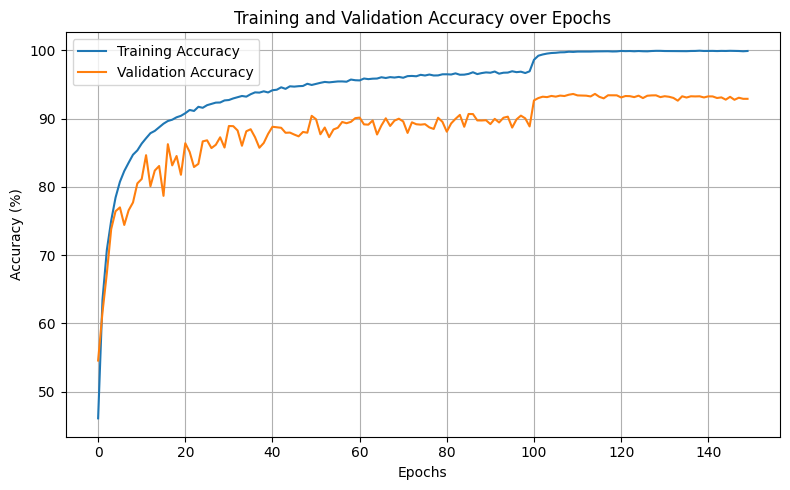

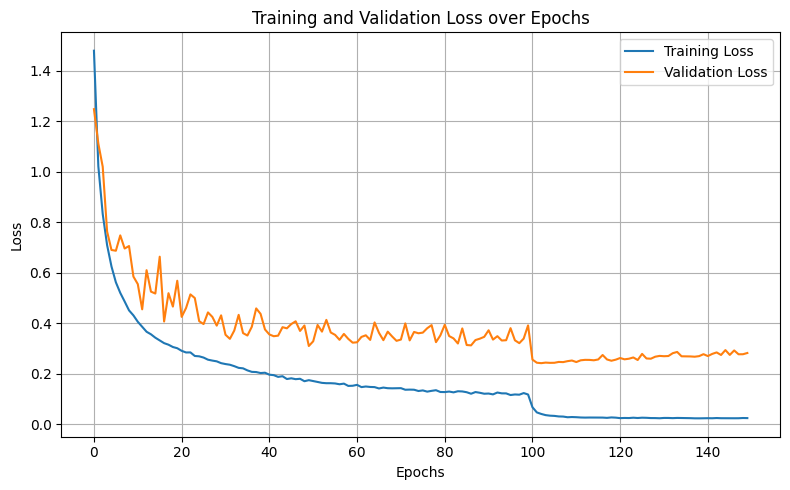

In [42]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(validation_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def unpickle(file):

	with open(file, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes')
	return dict

nolabel_file = './cifar_test_nolabel.pkl'

no_label = unpickle(nolabel_file)

transform_unseen = transforms.Compose([
    transforms.ToTensor(),                 # Scale to [0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # Normalize
])

class Cifar10(torch.utils.data.Dataset):

    def __init__(self, data):
        super().__init__()
        label = data.get(b'labels', None)
        self.ids = [int(x) for x in data[b'ids']]
        data = [transform_unseen(x) for x in data[b'data']]
        # self.ids_to_data = {}
        self.x_data = torch.stack(data).to(device)

        
        # self._construct_id_hash()

        if label is not None:
            self.y_data = torch.tensor(label, dtype=torch.uint8).to(device)
        else:
            self.y_data = None
    
    def __len__(self):
        return len(self.x_data)  # required
    
    def __getitem__(self, idx):
        data = self.x_data[idx]
        return data

def visualize(input, counter):
    # Convert the tensor to (H, W, C) format using .permute()
    if counter < 5:
        print(input.shape)
        image_np = input[0].permute(1, 2, 0).cpu().numpy()
        
        # Plot the image
        plt.imshow(image_np)
        plt.axis('off')  # Optional: turn off axes for better visualization
        plt.show()

In [ ]:
load_model_name = "resnet_full_checkpoint_93.66.pth"
model = ResNetSE().to(device)  # Replace with your model class and arguments
model_path = "/scratch/nd2745/checkpoints"
checkpoint = torch.load(f"{model_path}/{load_model_name}")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Prepare unlabeled data and DataLoader
unlabeled_data = no_label  # Replace with your input data (e.g., images or tensors)
dataset = Cifar10(unlabeled_data)
unlabelled_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


# Run inference on unlabeled data
counter = 0
predictions = []
with torch.no_grad():
    for batch in unlabelled_dataloader:
        
        batch = batch.to(device).float().view(-1, 3, 32, 32)
        counter += 1
        visualize(batch, counter)
        outputs = model(batch)
        predicted_labels = torch.argmax(outputs, dim=1)
        predictions.extend(predicted_labels.cpu().numpy())


In [ ]:
print(type(no_label))
print(no_label.keys())  # if it's a dict


In [ ]:
output = {'ID': [int(x) for x in no_label[b'ids']], 'Labels': [int(x) for x in predictions]}

In [ ]:
with open(f'/scratch/nd2745/DL_Project_1/results/output_{model_name}_transformed.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header (keys of the dictionary)
    writer.writerow(output.keys())
    
    # Write the rows (values of the dictionary, zipped together)
    writer.writerows(zip(*output.values()))

# Optional: Print confirmation
print("CSV file has been created successfully!")